# CNN with a Trainable Embedding Layer
## Removing judgement

In [8]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [9]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

## Build test and training sets & define preprocessing

In [10]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [11]:
train_data = pd.read_csv('../data/train_80_10_10_doc_type.csv')
val_data = pd.read_csv('../data/val_80_10_10_doc_type.csv')
test_data = pd.read_csv('../data/test_80_10_10_doc_type.csv')

In [12]:
train_no_judgement = train_data[train_data.doc_type != 'judgment']
train_no_judgement.to_csv('../data/train_no_judge.csv')
val_no_judgement = val_data[val_data.doc_type != 'judgment']
val_no_judgement.to_csv('../data/val_no_judge.csv')
test_no_judgement = test_data[test_data.doc_type != 'judgment']
test_no_judgement.to_csv('../data/test_no_judge.csv')

In [13]:
train, test, preproc = text.texts_from_csv('../data/train_no_judge.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/val_no_judge.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 12274
Nrows: 486
486 train sequences
train sequence lengths:
	mean : 1152
	95percentile : 2251
	99percentile : 4587
x_train shape: (486,5000)
y_train shape: (486, 2)
Is Multi-Label? False
57 test sequences
test sequence lengths:
	mean : 1103
	95percentile : 2741
	99percentile : 3279
x_test shape: (57,5000)
y_test shape: (57, 2)


## Build the model

In [14]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [15]:
model = _build_cnn(MAXLEN, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [16]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     6432        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     9632        embedding[0][0]                  
______________________________________________________________________________________________

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 486 samples
Epoch 1/5
486/486 [==============================] - 5s 10ms/sample - loss: 0.6852 - accuracy: 0.5535
Epoch 2/5
486/486 [==============================] - 3s 6ms/sample - loss: 0.6865 - accuracy: 0.5535
Epoch 3/5
486/486 [==============================] - 3s 6ms/sample - loss: 0.6653 - accuracy: 0.6173
Epoch 4/5
486/486 [==============================] - 3s 6ms/sample - loss: 1.5848 - accuracy: 0.5947
Epoch 5/5
 64/486 [==>...........................] - ETA: 2s - loss: 22.9080 - accuracy: 0.5156

done.
Visually inspect loss plot and select learning rate associated with falling loss


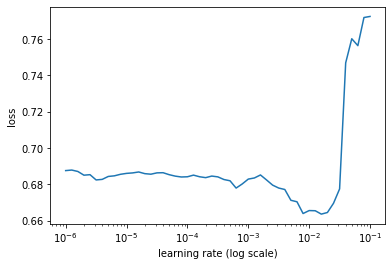

In [17]:
learner.lr_find(show_plot=True)

### Train

In [23]:
learner.autofit(lr=0.01)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 486 samples, validate on 57 samples
Epoch 1/1024
486/486 [==============================] - 3s 6ms/sample - loss: 0.6068 - accuracy: 0.8374 - val_loss: 1.5231 - val_accuracy: 0.6316
Epoch 2/1024
486/486 [==============================] - 3s 6ms/sample - loss: 0.5694 - accuracy: 0.7901 - val_loss: 1.2311 - val_accuracy: 0.6842
Epoch 3/1024
486/486 [==============================] - 3s 6ms/sample - loss: 0.2824 - accuracy: 0.8848 - val_loss: 0.9510 - val_accuracy: 0.6140
Epoch 4/1024
486/486 [==============================] - 3s 6ms/sample - loss: 0.0478 - accuracy: 0.9856 - val_loss: 1.8720 - val_accuracy: 0.6667
Epoch 5/1024
480/486 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9896
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).

## Examine results

In [19]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.70      0.89      0.78        36

    accuracy                           0.68        57
   macro avg       0.67      0.61      0.61        57
weighted avg       0.67      0.68      0.65        57



array([[ 7, 14],
       [ 4, 32]])

In [20]:
val_x = list(pd.read_csv('../data/val_80_10_10.csv')['cleaned_contents'])
y_val_proba = np.array(predictor.predict_proba(val_x))[:,1]
y_val_hat = np.array(predictor.predict(val_x), dtype=np.int64)
val_y = np.array(pd.read_csv('../data/val_80_10_10.csv')['Discrimination_Label'])

NameError: name 'predictor' is not defined

In [21]:
test_x = list(pd.read_csv('../data/test_80_10_10.csv')['cleaned_contents'])
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
y_hat = np.array(predictor.predict(test_x), dtype=np.int64)
y = np.array(pd.read_csv('../data/test_80_10_10.csv')['Discrimination_Label'])

In [22]:
print(classification_report(y, y_hat))
print(confusion_matrix(y, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.46      0.58        37
           1       0.66      0.89      0.76        44

    accuracy                           0.69        81
   macro avg       0.72      0.67      0.67        81
weighted avg       0.71      0.69      0.67        81

[[17 20]
 [ 5 39]]


## Explain a prediction

In [ ]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')